In [39]:
###################
#インポート
###################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline


In [40]:
###################
#データセットをダウンロード
###################

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()



print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print("X_train[0]:{}".format(X_train[0])) #------検証中--------

print("------検証中---------")


(60000, 28, 28)
(10000, 28, 28)
uint8
X_train[0]:[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0  

In [41]:
###################
#平滑化(1, 28, 28)の各画像を(1, 784)に変換
###################

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
print("X_train:{}".format(X_train)) #------検証中--------
print("X_test:{}".format(X_test)) #------検証中--------


X_train:[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
X_test:[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [42]:
###################
#前処理データをフロート型にして255で割ることで正規化
###################

#データの型を変換
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

#データを0から1の数字に変換
X_train /= 255
X_test /= 255

print(X_train.max()) # 1.0
print(X_train.min()) # 0.0


1.0
0.0


In [43]:
###################
#ｙの値の0-9をone-hot表現に変換
###################

#encでワンホットエンコーダをインスタンス化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

#y-trainとy-testをone-hot表現に変換（np.newaxisで次元を追加している）
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

#y_train.shape：６００００個の０から９の数字(画像データではない）
print(y_train.shape) # (60000,)

#y_train_one_hot.shape：６００００個の０から９を表す0と1のデータ
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64
print("y_train_one_hot[0]:{}".format(y_train_one_hot[0])) #------検証中--------


(60000,)
(60000, 10)
float64
y_train_one_hot[0]:[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [44]:
###################
#Xとｙのトレーニングデータを分割
###################

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) #
print(y_val) #


(48000, 784)
(12000, 784)
[6 3 7 ... 3 1 7]


In [45]:
###################
#【問題1】全結合層のクラス化
###################
class FC:
    """全結合層"""
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        """コンストラクタ
        Parameters
        ----------
        n_nodes1 : 前の層のノード数
        n_nodes2 : 当該層のノード数
        initializer : 初期化インスタンス
        optimizer : 勾配更新手法
        """
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2

        # 初期化インスタンスの関数実行
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)

        # 最適化インスタンス
        self.optimizer = optimizer

        # 勾配更新の際に使用（AdaGradのみ）
        self.HW = 0
        self.HB = 0

    def forward(self, X):
        """順伝播
        Parameters
        ----------
        X : 順伝播されてきた値
        """
        # 逆伝播時に使用
        self.Z = X
        # 順伝播計算部分本体
        self.A = X @ self.W + self.B
        return self.A

    def backward(self, dA):
        """逆伝播
        Parameters
        ----------
        dA : 前の層から逆伝播してきた値（活性化関数の逆伝播の値が入ってくる）
        """
        # バイアス項の勾配
        self.dB = np.sum(dA, axis=0)
        # バイアス項以外の勾配
        self.dW = self.Z.T @ dA
        # 逆伝播させる値
        self.dZ = dA @ self.W.T
        # 重み更新
        self = self.optimizer.update(self)
        return self.dZ


In [46]:
###################
#問題2　初期化方法のクラス化
###################


class SimpleInitializer:
    """各種重みの初期化"""
    def __init__(self, sigma):
        """コンストラクタ
        Parameters
        ----------
        sigma : 重みの初期化の際のガウス分布の標準偏差
        """
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes1 : 前の層のノード数
        n_nodes2 : 当該層のノード数
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes2 : 当該層のノード数
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B


In [47]:
###################
#問題3　最適化手法のクラス化
###################


class SGD:
    """勾配更新手法"""
    def __init__(self, lr):
        """コンストラクタ
        Parameters
        ----------
        lr : 学習率
        """
        self.lr = lr

    def update(self, layer):
        """更新
        Parameters
        ----------
        layer : FCクラスのインスタンス
        """
        layer.W -= self.lr * layer.dW / len(layer.Z)
        layer.B -= self.lr * layer.dB / len(layer.Z)
        return layer


In [48]:
###################
#問題4　活性化関数のクラス化
###################

class Sigmoid:
    """シグモイド関数"""
    def forward(self, A):
        """順伝播
        Parameters
        ----------
        A : 順伝播されてきた値
        """
        self.A = A
        Z = 1 / (1 + np.exp(-self.A))
        return Z

    def backward(self, dZ):
        """逆伝播
        Parameters
        ----------
        dZ : 逆伝播されてきた値
        """
        dA = dZ * ((1 / (1 + np.exp(-self.A))) - (1 / (1 + np.exp(-self.A)))**2)
        return dA

In [49]:
class Tanh:
    """tanh関数"""
    def forward(self, A):
        """順伝播
        Parameters
        ----------
        A : 順伝播されてきた値
        """
        self.A = A
        Z = np.tanh(self.A)
        return Z

    def backward(self, dZ):
        """逆伝播
        Parameters
        ----------
        dZ : 逆伝播されてきた値
        """
        dA = dZ * (1 - np.tanh(self.A)**2)
        return dA

In [50]:
class Softmax:
    """Softmax関数"""
    def forward(self, A):
        """順伝播
        Parameters
        ----------
        A : 順伝播されてきた値
        """
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return Z

    def backward(self, Z, y):
        """逆伝播
        Parameters
        ----------
        Z : 出力値
        y : 正解データ
        """
        # 逆伝播の値
        dA = Z - y
        # 損失
        loss = - np.sum(y * np.log(Z)) / len(y)
        return dA, loss


In [51]:
###################
#問題5　ReLUクラスの作成
###################

class ReLU:
    """ReLU関数"""
    def forward(self, A):
        """順伝播
        Parameters
        ----------
        A : 順伝播されてきた値
        """
        self.A = A
        Z = np.maximum(0, A)
        return Z

    def backward(self, dZ):
        """逆伝播
        Parameters
        ----------
        dZ : 逆伝播されてきた値
        """
        dA = dZ * np.where(self.A > 0, 1, 0)
        return dA


In [52]:
###################
#問題6　重みの初期値
###################

class XavierInitializer:
    """Xavierの初期化クラス"""
    def __init__(self, sigma):
        """コンストラクタ
        Parameters
        ----------
        sigma : 使用されていない

        Overview
        ----------
        """
        _ = sigma

    def W(self, n_nodes1, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes1 : 前の層のノード数
        n_nodes2 : 当該層のノード数
        """
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes2 : 当該層のノード数
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [53]:
class HeInitializer:
    """Heの初期化クラス"""
    def __init__(self, sigma):
        _ = sigma

    def W(self, n_nodes1, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes1 : 前の層のノード数
        n_nodes2 : 当該層のノード数
        """
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes2 : 当該層のノード数
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B


In [54]:
###################
#問題7　最適化手法
###################


class AdaGrad:
    """最適化手法（AdaGrad）"""
    def __init__(self, lr):
        """コンストラクタ
        Parameters
        ----------
        lr : 学習率
        """
        self.lr = lr

    def update(self, layer):
        """コンストラクタ
        Parameters
        ----------
        layer : layerインスタンス
        """
        layer.HW += layer.dW * layer.dW
        layer.HB += layer.dB * layer.dB
        delta = 1e-7 # 0割エラー防止のため
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.HW) + delta) / len(layer.Z)
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.HB) + delta) / len(layer.Z)
        return layer


In [55]:
###################
#問題8　クラスの完成
###################

class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        """通常のコンストラクタと同様の働き
        Parameters
        ----------
        X : 説明変数（画像の1次元データ）
        y : 目的変数（ラベル）
        batch_size : 必要なミニバッチのデータ数
        seed : ランダムシード固定
        """
        # ランダムシードの固定（学習ごとに同じ生成順）
        np.random.seed(seed)
        # バッチ数のメンバ変数
        self.batch_size = batch_size
        # データ全体の長さ分のインデックスをランダムに並べ替え
        # np.random.permutation:配列をランダムに並べ替え
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        # 並べ替えたインデックスと同じ順番で説明変数と目的変数を並べ替え
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        # データ数をバッチ数で割って、何回呼び出せば、全データを学習したことになるかの判定
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __iter__(self):
        # 何回目の呼び出しか
        self._counter = 0
        return self

    def __next__(self):
        # 全データを学習すればストップ
        if self._counter >= self._stop:
            raise StopIteration()
        # 並び変えた_X,_yの何番目のインデックスを採用するか
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        # returnする前にカウンタに+1しておく
        self._counter += 1
        # 説明変数と目的変数を返す
        return self._X[p0:p1], self._y[p0:p1]


In [56]:
class ScratchDeepNeuralNetrowkClassifier():

    def __init__(self,batch_size=20,n_features=784,n_nodes1 =400,n_nodes2 = 200,n_output =10,lr =0.005,epoch=10,sigma=0.02,optimizer=SGD, initializer=HeInitializer,activater=ReLU,output_activater=Softmax,verbose=True):
        """コンストラクタ
        Parameters
        ----------
        batch_size : バッチサイズ（default:20)
        n_features : 説明変数の数（default:784)
        n_nodes1 : 前の層のノード数（default:400)
        n_nodes2 : 当該層のノード数（default:200)
        n_output : 出力層のノード数（default:10)
        sigma : 初期化時のパラメータ（default:0.02)
        lr : 学習率（default:0.005)
        verbose : 計算過程の出力（default:True)
        epoch : 学習回数（default:10)
        optimizer : 最適化手法（default:SGD)
        initializer : 初期化方法（default:HeInitializer）
        activater : 活性化関数（default:ReLU）
        """
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.lr = lr
        self.epoch = epoch
        self.optimizer = optimizer
        self.sigma = sigma
        self.initializer = initializer
        self.activater = activater
        self.output_activater = output_activater
        self.verbose = verbose

    def fit(self, X, y, X_val=None, y_val=None):
        """学習
        Parameters
        ----------
        X : 訓練データの説明変数
        y : 訓練データの目的変数
        X_val : 評価データの説明変数
        y_val : 評価データの目的変数
        """
        # lossの記録用配列
        self.loss_train = []
        self.loss_val = []
        # 最適化手法の初期化
        optimizer = self.optimizer(self.lr)
        # 各層の初期化
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), optimizer)
        self.activation1 = self.activater()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), optimizer)
        self.activation2 = self.activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation3 = self.output_activater()

        # 学習回数分ループ
        for i in range(self.epoch):
            # ミニバッチイテレータ生成
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            # ミニバッチイテレータループ
            for mini_X, mini_y in get_mini_batch:
                ## 順伝播
                # 1層目
                A1 = self.FC1.forward(mini_X)
                Z1 = self.activation1.forward(A1)
                # 2層目
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                # 3層目
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                ## 逆伝播
                dA3, loss = self.activation3.backward(Z3, mini_y)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1)

            # 過程出力
            if self.verbose:
                ## 順伝播
                # 1層目
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                # 2層目
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                # 3層目
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                # 損失計算と記録
                loss = self.activation3.backward(Z3, y)[1]
                self.loss_train.append(loss)
                print('epoch:%d train_loss:%f'%(i,loss))
                # 評価データ見る
                if X_val is not None:
                    ## 順伝播
                    # 1層目
                    A1 = self.FC1.forward(X_val)
                    Z1 = self.activation1.forward(A1)
                    # 2層目
                    A2 = self.FC2.forward(Z1)
                    Z2 = self.activation2.forward(A2)
                    # 3層目
                    A3 = self.FC3.forward(Z2)
                    Z3 = self.activation3.forward(A3)
                    # 損失計算と記録
                    self.loss_val.append(self.activation3.backward(Z3, y_val)[1])

    def predict(self, X):
        """予測
        Parameters
        ----------
        X : 入力配列
        """
        ## 順伝播
        # 1層目
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        # 2層目
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        # 3層目
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        # 最も大きいインデックスを採用
        return np.argmax(Z3, axis=1)


epoch:0 train_loss:2.304134
epoch:1 train_loss:2.284676
epoch:2 train_loss:2.268171
epoch:3 train_loss:2.255812
epoch:4 train_loss:2.244088
epoch:5 train_loss:2.232042
epoch:6 train_loss:2.223271
epoch:7 train_loss:2.213170
epoch:8 train_loss:2.202052
epoch:9 train_loss:2.193318
epoch:10 train_loss:2.183267
epoch:11 train_loss:2.173420
epoch:12 train_loss:2.167817
epoch:13 train_loss:2.154404
epoch:14 train_loss:2.146236
epoch:15 train_loss:2.138715
epoch:16 train_loss:2.127486
epoch:17 train_loss:2.116786
epoch:18 train_loss:2.109711
epoch:19 train_loss:2.098999
epoch:20 train_loss:2.088091
epoch:21 train_loss:2.079391
epoch:22 train_loss:2.070956
epoch:23 train_loss:2.058478
epoch:24 train_loss:2.050403
epoch:25 train_loss:2.038642
epoch:26 train_loss:2.032555
epoch:27 train_loss:2.017881
epoch:28 train_loss:2.007003
epoch:29 train_loss:1.994378
epoch:30 train_loss:1.981007
epoch:31 train_loss:1.969949
epoch:32 train_loss:1.962599
epoch:33 train_loss:1.952041
epoch:34 train_loss:1.93

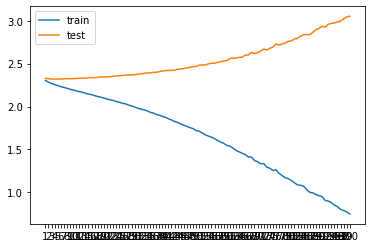

In [57]:
###################
#問題9　学習と推定
###################


dnn = ScratchDeepNeuralNetrowkClassifier(epoch=100)

dnn.fit(X_train[:4000], y_train_one_hot[:4000], X_val[:2000], y_test_one_hot[:2000])


pred = dnn.predict(X_val)
accuracy_score(y_val, pred)


plt.plot(list(range(1, dnn.epoch+1)), dnn.loss_train, label='train')
plt.plot(list(range(1, dnn.epoch+1)), dnn.loss_val, label='test')
plt.legend()
plt.xticks(list(range(1, dnn.epoch+1)));

